## Introduction

Kaggle recently published the results of their 2017 data science survey. As someone with a budding interest in data science, I figured I'd try to find how the results could be useful to people like me, who are trying to figure out how to get started.

### Installing necessary packages

In [1]:
library(data.table)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(tibble)

### Loading data

I like using tibbles for large data frames, as they make it easier to view in the R interactive prompt.

In [2]:
results <- as.tibble(suppressWarnings(fread("./data/multipleChoiceResponses.csv")))

We can easily see how many people responded to the survey...

In [3]:
nrow(results)

[1] 16716

...and how many questions were asked.

In [4]:
ncol(results)

[1] 228

With 228(!) questions and 17,000 respondents, there's clearly a lot to analyze. Let's get started!

### Theme

I like making my data visualizations look nice, so I'll be building off of this theme for most of my graphs.

In [5]:
jack_theme <- theme(
    plot.background = element_rect(fill = "#eeeeee"),
    panel.background = element_rect(fill = "#eeeeee"),
    legend.background = element_rect(fill = "#eeeeee"),
    legend.title = element_text(size = 12, family = "Helvetica", face = "bold"),
    legend.text = element_text(size = 9, family = "Helvetica"),
    panel.grid.major = element_line(size = 0.4, linetype = "solid", color = "#cccccc"),
    panel.grid.minor = element_line(size = 0),
    plot.title = element_text(size = 20, family = "Helvetica", face = "bold", hjust = 0.5, margin = margin(b = 20)),
    axis.title = element_text(size = 14, family = "Helvetica", face = "bold"),
    axis.title.x = element_text(margin = margin(t = 20)),
    axis.title.y = element_text(margin = margin(r = 20)),
    axis.ticks = element_blank(),
    plot.margin = unit(c(1, 1, 1, 1), "cm")
)

## Programming language

From what I understand, one of the first questions many data scientists have to answer is which language they want to write their code in. In this graph, we'll see how Python and R stack up against each other as recommendations based on participants' job titles.

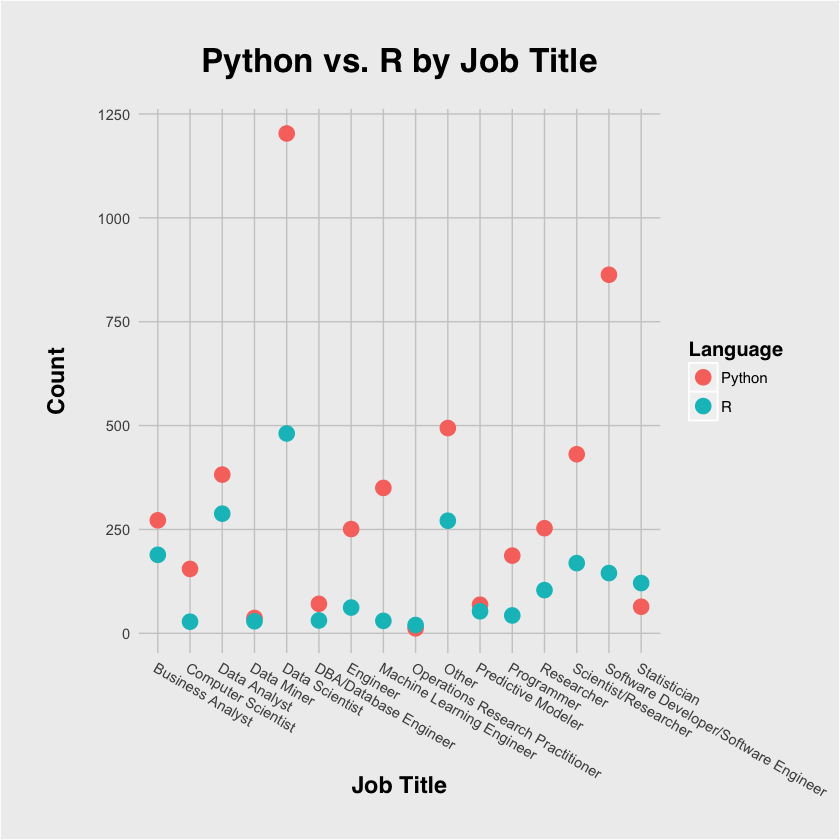

In [6]:
results %>%
    rename(Language = LanguageRecommendationSelect, title = CurrentJobTitleSelect) %>%
    filter(Language == "R" | Language == "Python") %>%
    filter(title != "") %>%
    group_by(title, Language) %>%
    count() %>%
    ggplot(aes(title, n, color = Language)) +
    ggtitle("Python vs. R by Job Title") +
    labs(x = "Job Title", y = "Count") +
    geom_point(size = 4) +
    jack_theme +
    theme(
        axis.text.x = element_text(angle = 330, hjust = 0),
        axis.title.x = element_text(margin = margin(t = -13))
    )

As we can see, **Python is favored for beginners over R in almost every scenario**, and notably so for data scientists, software developers, and machine learning engineers. However, R is slightly favored by statisticians.

## Resources for learning

One of the first questions in the survey asked participants how useful certain resources are for learning data science skills. For our first graph, we'll plot each resource's usefulness against its popularity. We can see if some resources are overhyped, or if some aren't being used enough. Popularity is determined by how many people answered the question for this resource, and usefulness is computed as a weighted average, with 1 point awarded for each "very useful" answer, half a point for each "somewhat useful" answer, and 0 points for each "not useful" answer.

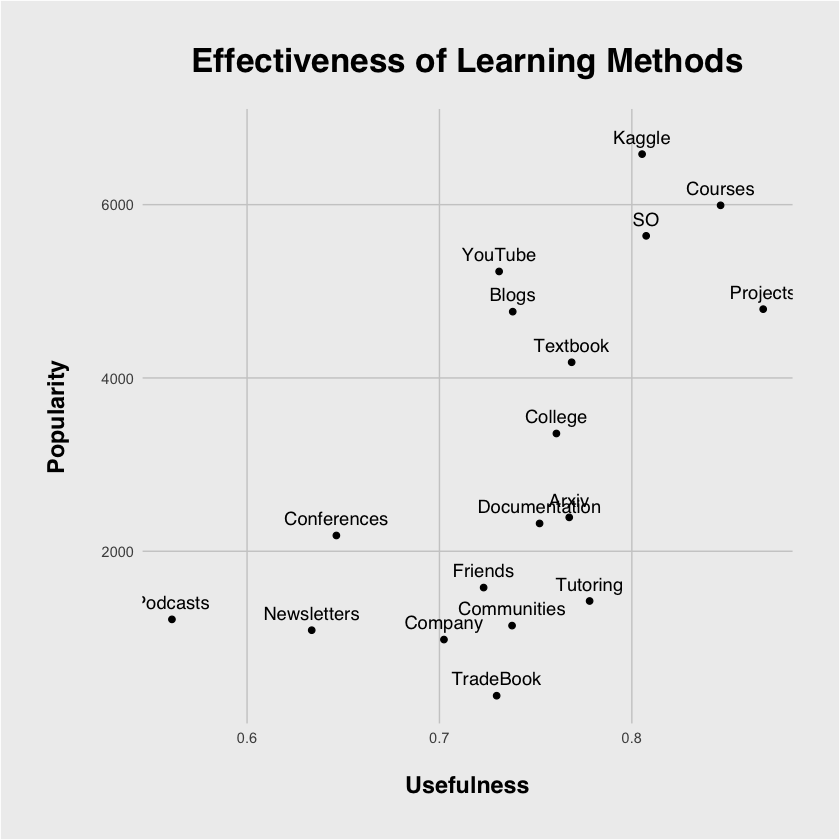

In [7]:
# Get all column names that begin with "LearningPlatformUsefulness"
platforms <- grep("^LearningPlatformUsefulness", names(results), value=T)

names <- c()
popularities <- c()
scores <- c()

for (platform in platforms) {
    usefulness <- results %>%
        group_by_(platform) %>%
        count()
    
    # Popularity = the number of people who responded to this question
    popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4]
    
    # Usefulness = a weighted average determining the usefulness of this platform
    score <- (usefulness[[2]][2] * 0 + usefulness[[2]][3] * 0.5 + usefulness[[2]][4] * 1) / popularity
    
    names <- c(names, gsub("LearningPlatformUsefulness", "", platform))
    popularities <- c(popularities, popularity)
    scores <- c(scores, score)
}

scores_df <- data.frame(
    Popularity = popularities,
    Usefulness = scores,
    Name = names
)

ggplot(scores_df, aes(x = Usefulness, y = Popularity)) +
    ggtitle("Effectiveness of Learning Methods") +
    geom_point() +
    geom_text(aes(label = Name, family = "Helvetica"), nudge_y = 200) +
    jack_theme

We can see a couple of results that are immediately obvious. Podcasts, newsletters, and conferences all scored the lowest as far as how useful they are for learning, while **Kaggle competitions, Stack Overflow, online courses, and projects scored the highest**. We can also see that while many people love watching YouTube tutorials and reading blogposts, these may not be the most effective ways to learn about data science.

## Important job skills

The same graph can be made for the questions that were asked regarding which technologies were considered to be most important on the job.

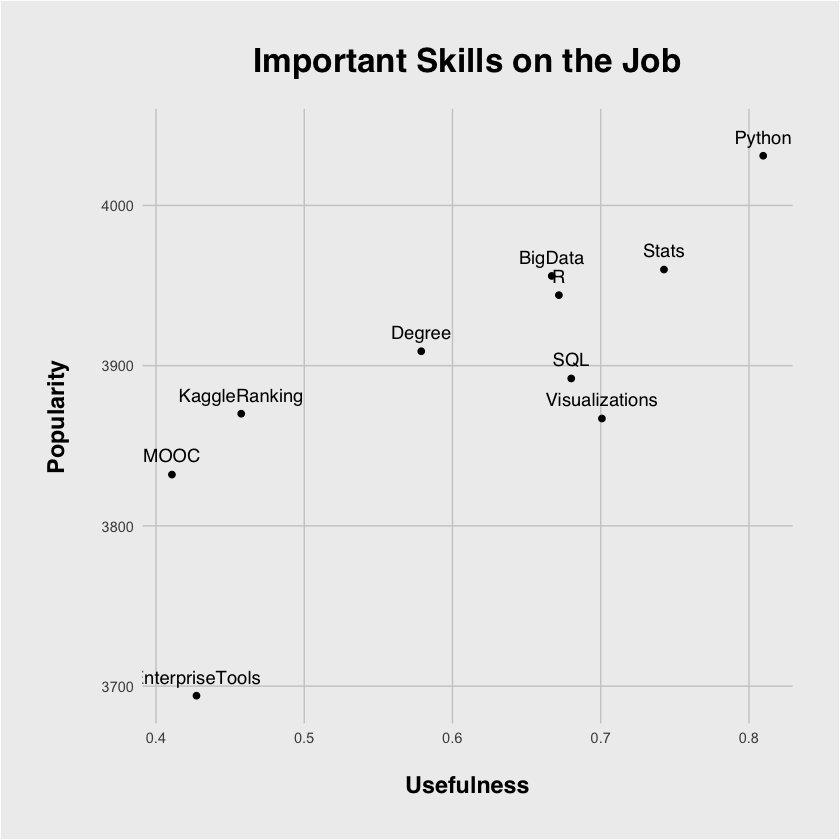

In [8]:
# Get all column names that begin with "JobSkillImportance" and end in a letter
platforms <- grep("^JobSkillImportance.*[A-z]$", names(results), value=T)

names <- c()
popularities <- c()
scores <- c()

for (platform in platforms) {
    usefulness <- results %>%
        group_by_(platform) %>%
        count()
    
    # Popularity = the number of people who responded to this question
    popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4]
    
    # Usefulness = a weighted average determining the usefulness of this platform
    score <- (usefulness[[2]][2] * 1 + usefulness[[2]][3] * 0.5 + usefulness[[2]][4] * 0) / popularity
    
    names <- c(names, gsub("JobSkillImportance", "", platform))
    popularities <- c(popularities, popularity)
    scores <- c(scores, score)
}

scores_df <- data.frame(
    Popularity = popularities,
    Usefulness = scores,
    Name = names
)

ggplot(scores_df, aes(x = Usefulness, y = Popularity)) +
    ggtitle("Important Skills on the Job") +
    geom_point() +
    geom_text(aes(label = Name, family = "Helvetica"), nudge_y = 12) +
    jack_theme

Interestingly enough, MOOCs scored the lowest in terms of usefulness, yet online courses scored the second highest in the last question. Therefore, while courses can be good for learning about data science, they should not be shown as a form of qualification to employers. We can see that **knowledge of Python, advanced statistics, and vizualization tools ranked the highest** in terms of skills that are useful in getting data science jobs.

## Tools in the real world

One of the survey's questions involved asking respondents how often they used certain technologies at work. Instead of making a scatterplot for this one, I put them into a table with multiple columns for job titles, since the responses essentially measured popularity anyway, so it may not have made sense to put it on a scatterplot. More weight was given to technologies that were reportedly used more often, and by more people.

In [9]:
# Get all column names that begin with "WorkToolsFrequency" and end in a letter
platforms <- grep("^WorkToolsFrequency.*[A-z]$", names(results), value=T)
positions <- c("All", "Data Scientist", "Software Developer/Software Engineer", "Researcher", "Machine Learning Engineer")

technologies <- matrix("", 10, length(positions))
colnames(technologies) <- positions
rownames(technologies) <- 1:10

i <- 1

for (position in positions) {
    names <- c()
    popularities <- c()
    
    if (position == "All") {
        position_results <- results
    } else {
        position_results <- results %>% filter(CurrentJobTitleSelect == position)
    }
    
    for (platform in platforms) {
        usefulness <- position_results %>%
            group_by_(platform) %>%
            count()
        
        # Popularity = the number of people who responded to this question
        popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4] + usefulness[[2]][5]
        
        # Usefulness = a weighted average determining how much this tool was used
        score <- (usefulness[[2]][2] * 1 + usefulness[[2]][3] * 0.67 + usefulness[[2]][4] * 0.33 + usefulness[[2]][5] * 0) / popularity
        
        names <- c(names, as.character(gsub("WorkToolsFrequency", "", platform)))
        popularities <- c(popularities, popularity * score)
    }
    
    scores_df <- data.frame(
        Popularity = popularities,
        Name = names
    )
    
    technologies[, i] <- head(as.character((scores_df %>% arrange(desc(Popularity)))$Name), n = 10)
    i <- i + 1
}

technologies

,All,Data Scientist,Software Developer/Software Engineer,Researcher,Machine Learning Engineer
1,Python,Python,Python,Python,Python
2,SQL,SQL,SQL,R,Jupyter
3,R,R,Jupyter,Jupyter,TensorFlow
4,Jupyter,Jupyter,Unix,MATLAB,Unix
5,Unix,Unix,Java,TensorFlow,SQL
6,TensorFlow,AWS,AWS,SQL,R
7,AWS,Spark,NoSQL,Unix,AWS
8,Tableau,TensorFlow,R,C,C
9,Java,Hadoop,TensorFlow,Java,Java
10,NoSQL,Tableau,C,Excel,MATLAB


Here, we can see a couple of insightful trends. Python, SQL, R, Jupyter, Unix, and TensorFlow are all ubiquitous. However, Spark, Hadoop, and Tableau are unique to data scientists, NoSQL is unique to software engineers, and MATLAB is unique to researchers and machine learning engineers. While some of these could have been guessed, this is confirmation of the tools that are good to learn for anyone aspiring to have any of these jobs in the future.

## Important job methods

Again, we can make the same table but for methods used on the job rather than skills. Here, we see the top 10 methods used for all respondents, and then by the four job titles that we isolated in the last question.

In [10]:
results_names <- names(results)
results_names[results_names == "WorkMethodsFrequencyA/B"] <- "WorkMethodsFrequencyAB"
results_names[results_names == "WorkMethodsFrequencyCross-Validation"] <- "WorkMethodsFrequencyCrossValidation"
names(results) <- results_names

# Get all column names that begin with "WorkToolsFrequency" and end in a letter
methods <- grep("^WorkMethodsFrequency.*[A-z]$", names(results), value=T)
positions <- c("All", "Data Scientist", "Software Developer/Software Engineer", "Researcher", "Machine Learning Engineer")

technologies <- matrix("", 10, length(positions))
colnames(technologies) <- positions
rownames(technologies) <- 1:10

i <- 1

for (position in positions) {
    names <- c()
    popularities <- c()
    
    if (position == "All") {
        position_results <- results
    } else {
        position_results <- results %>% filter(CurrentJobTitleSelect == position)
    }
    
    for (method in methods) {
        usefulness <- position_results %>%
            group_by_(method) %>%
            count()
        
        # Popularity = the number of people who responded to this question
        popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4] + usefulness[[2]][5]
        
        # Usefulness = a weighted average determining how much this tool was used
        score <- (usefulness[[2]][2] * 1 + usefulness[[2]][3] * 0.67 + usefulness[[2]][4] * 0.33 + usefulness[[2]][5] * 0) / popularity
        
        names <- c(names, as.character(gsub("WorkMethodsFrequency", "", method)))
        popularities <- c(popularities, popularity * score)
    }
    
    scores_df <- data.frame(
        Popularity = popularities,
        Name = names
    )
    
    technologies[, i] <- head(as.character((scores_df %>% arrange(desc(Popularity)))$Name), n = 10)
    i <- i + 1
}

technologies

,All,Data Scientist,Software Developer/Software Engineer,Researcher,Machine Learning Engineer
1,DataVisualization,DataVisualization,DataVisualization,DataVisualization,CrossValidation
2,CrossValidation,CrossValidation,CrossValidation,CrossValidation,NeuralNetworks
3,LogisticRegression,LogisticRegression,NeuralNetworks,NeuralNetworks,DataVisualization
4,DecisionTrees,RandomForests,LogisticRegression,LogisticRegression,CNNs
5,RandomForests,DecisionTrees,DecisionTrees,PCA,NLP
6,TimeSeriesAnalysis,TimeSeriesAnalysis,TimeSeriesAnalysis,TimeSeriesAnalysis,LogisticRegression
7,NeuralNetworks,TextAnalysis,TextAnalysis,CNNs,RandomForests
8,PCA,EnsembleMethods,RandomForests,DecisionTrees,DecisionTrees
9,TextAnalysis,PCA,NLP,SVMs,PCA
10,KNN,GBM,AB,NLP,EnsembleMethods


We can see a number of trends in this table as well. Everyone is using data visualization, cross validation, logistic regression, and decision trees. Natural language processing and neural networks are understandably used more often by machine learning engineers, while software engineers are the only job title where A/B testing made an appearance.

## Majors and likely positions

I haven't started college yet, and as such, have not yet had to declare a major. However, intuitively I would think that some majors are much more likely than others to hold certain jobs.

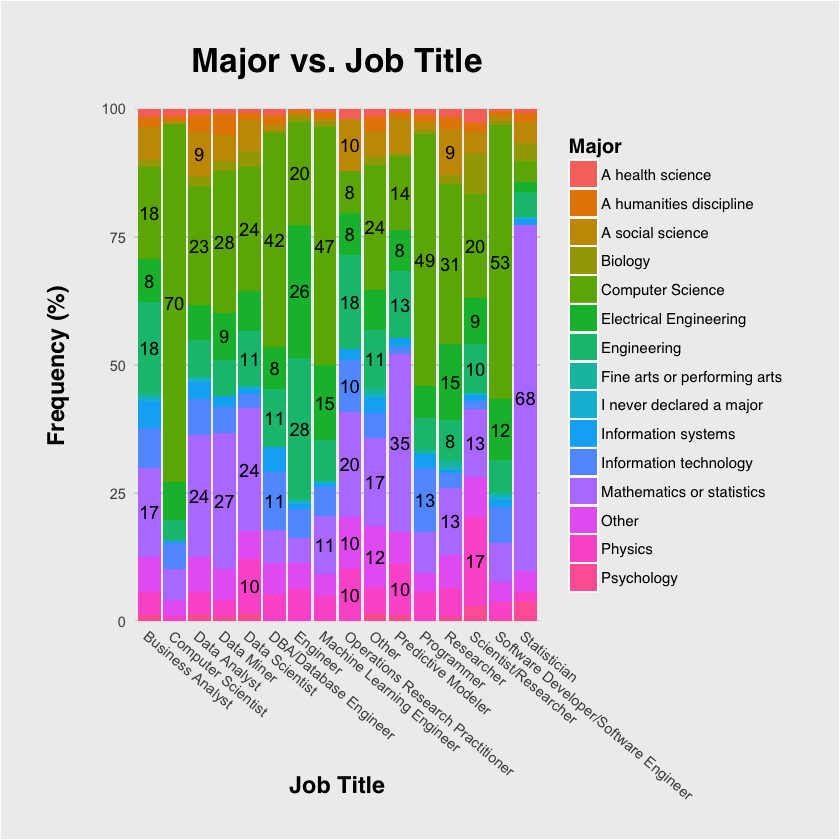

In [11]:
invisible(tryCatch({
    results[results$MajorSelect == "Engineering (non-computer focused)", ]$MajorSelect <- "Engineering"
    results[results$MajorSelect == "Information technology, networking, or system administration", ]$MajorSelect <- "Information technology"
    results[results$MajorSelect == "Management information systems", ]$MajorSelect <- "Information systems"
}, error = function(e){}))

results %>%
    rename(Major = MajorSelect, title = CurrentJobTitleSelect) %>%
    filter(title != "", Major != "") %>%
    group_by(title, Major) %>%
    summarize(n = n()) %>%
    mutate(freq = n / sum(n) * 100) %>%
    ggplot(aes(x = title, y = freq, fill = Major, label = ifelse(freq > 8, round(freq), ""))) +
    ggtitle("Major vs. Job Title") +
    labs(x = "Job Title", y = "Frequency (%)") +
    geom_bar(stat = "identity", position = position_stack()) +
    geom_text(position = position_stack(vjust = 0.5)) +
    scale_y_continuous(expand = c(0, 0)) +
    jack_theme +
    theme(
        axis.title.x = element_text(margin = margin(t = -15)),
        axis.text.x = element_text(angle = 320, hjust = 0)
    )

My intuition was right, majors end up being a pretty good predictor of what someone will do in the future. A few of these trends are obvious: computer science majors tend to become computer scientists, programmers, and software engineers, while math majors tend to become statisticians and predictive modelers. Most physics majors go into research, and non-CS engineering majors called themselves engineers.

What I personally like about this graph is, and this is true, at least one person from each major is fulfilling every job title. To me, this shows that no matter what you study in school, you can do what you want as long as the passion is there.